In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras import callbacks
from keras.models import Sequential
from keras.layers import Dense, Input
import os
from pickle import dump

In [3]:
n_test = 350000
k = 100
good_data = True
gseed = 6
degree = 4

current_dir = "./"  # Assuming current directory
dir = "/"
if os.name == "nt":
    current_dir = ".\\"
    dir = "\\"

In [4]:
""" ------------- LOADING DATA ----------------------------"""

if good_data:
    X = np.load("X_convex_{}_euler_1.npy".format(degree))
    Y = np.load("Y_convex_{}_euler_1.npy".format(degree))
else :
    X = np.random.randint(0, 100, size=(n_test * 2, 22))
    Y = np.random.randint(0, 2, size=(n_test * 2))

In [5]:
"""------------------NORMALIZING DATA-------------------------"""

X_train = X[:n_test,:22]
X_test = X[n_test:,:22]

Y_train = Y[:n_test]
Y_test = Y[n_test:]

X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)


In [6]:
"""---------------------DEFINING MODEL-------------------------"""

def custom_activation(x):
    return 0.5 * (1 + tf.math.sign(x)) * (x + 1/100) +  0.5 * (1 - tf.math.sign(x)) * tf.math.exp(tf.math.minimum(0.0,x)) / 100

def custom2_activation(x):
    return tf.where(x < 0, tf.exp(tf.math.minimum(0.0, x) * k) / k, x + 1/k)

model = Sequential([])
model.add(Input(shape=(22,)))
model.add(Dense(200, activation=custom_activation, kernel_initializer=tf.keras.initializers.RandomUniform(minval=-7.0, maxval=7.0, seed=gseed)))
model.add(Dense(200, activation=custom_activation))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=["accuracy"])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │         4,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,001 (175.79 KB)

 Trainable params: 45,001 (175.79 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
"""------------- MODEL FITTING -------------------"""

def learning_rate(epoch):
    if epoch < 100 :
        return 1e-3
    elif epoch < 140 :
        return 1e-4
    else :
        return 1e-5
    
learning_rate_cb = callbacks.LearningRateScheduler(learning_rate)

history = model.fit(X_train, Y_train, epochs=150, batch_size=16, callbacks=[learning_rate_cb])

Epoch 1/150
21875/21875 ━━━━━━━━━━━━━━━━━━━━ 31s 1ms/step - accuracy: 0.8327 - loss: 0.3944 - learning_rate: 0.0010
Epoch 2/150
21875/21875 ━━━━━━━━━━━━━━━━━━━━ 31s 1ms/step - accuracy: 0.9493 - loss: 0.1224 - learning_rate: 0.0010
Epoch 3/150
21875/21875 ━━━━━━━━━━━━━━━━━━━━ 32s 1ms/step - accuracy: 0.9606 - loss: 0.0965 - learning_rate: 0.0010
Epoch 4/150
21875/21875 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - accuracy: 0.9648 - loss: 0.0859 - learning_rate: 0.0010
Epoch 5/150
21875/21875 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - accuracy: 0.9684 - loss: 0.0779 - learning_rate: 0.0010
Epoch 6/150
21875/21875 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - accuracy: 0.9696 - loss: 0.0736 - learning_rate: 0.0010
Epoch 7/150
21875/21875 ━━━━━━━━━━━━━━━━━━━━ 32s 1ms/step - accuracy: 0.9720 - loss: 0.0688 - learning_rate: 0.0010
Epoch 8/150
21875/21875 ━━━━━━━━━━━━━━━━━━━━ 33s 1ms/step - accuracy: 0.9731 - loss: 0.0654 - learning_rate: 0.0010
Epoch 9/150
21875/21875 ━━━━━━━━━━━━━━━━━━━━ 30s 1ms/step - accuracy: 0.

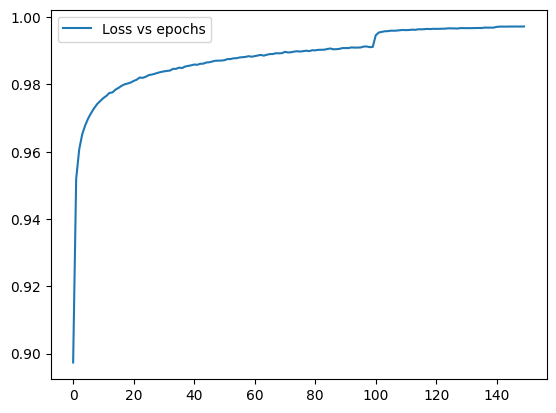

5079/5079 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9722 - loss: 0.2426
Test accuracy: 0.9724538326263428


In [8]:
"""------------------ EVALUATING MODEL ------------------"""
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(history.history['accuracy'][0:], label='Loss vs epochs')
ax.legend()
plt.show()

loss, accuracy = model.evaluate(X_test, Y_test)

print("Test accuracy:", accuracy)

In [9]:
"""------------------- SAVING MODEL AND SCALER --------------------"""
folderpath = current_dir + "NN" + dir
filename_model = folderpath + f"model_{degree}.keras"
while os.path.exists(filename_model):
    number = number + 1
    filename_model = folderpath + f"model_{degree}.keras"

filename_weights = folderpath + f"model_weights_{degree}.weights.h5"
filename_scaler = folderpath + f'scaler_{degree}.pkl'

model.save(filename_model)
model.save_weights(filename_weights)
dump(X_scaler, open(filename_scaler, 'wb'))

In [90]:
"""------------------ TEST ----------------------------------------"""

coeff = np.array([[0.94023082,6.97173563,-15.99134392,    8.91103779,    0.82695289,
   25.02515934,  -28.04553872,  -25.50761266,    9.46243293,   14.55959669,
 -172.7153104,   159.77415504,  -38.62615735,   22.49232082,  130.25269078,
 -183.92550277,   10.60521502,   55.00973079,   11.18036212,   23.97881451,
   61.74909799,   -4.73687212]])

M = np.array([[9, 18, 27, 18, 9, 18, 18, 18, 9, 18, 18, 18, 18, 9, 0, 0, 18, 18, 18, 18, 18, 9]])

model.predict(X_scaler.transform(coeff))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


array([[0.]], dtype=float32)